In [1]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score # и другие метрики
from sklearn.cluster import KMeans # а также другие алгоритмы

In [2]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(X[:, 0], X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

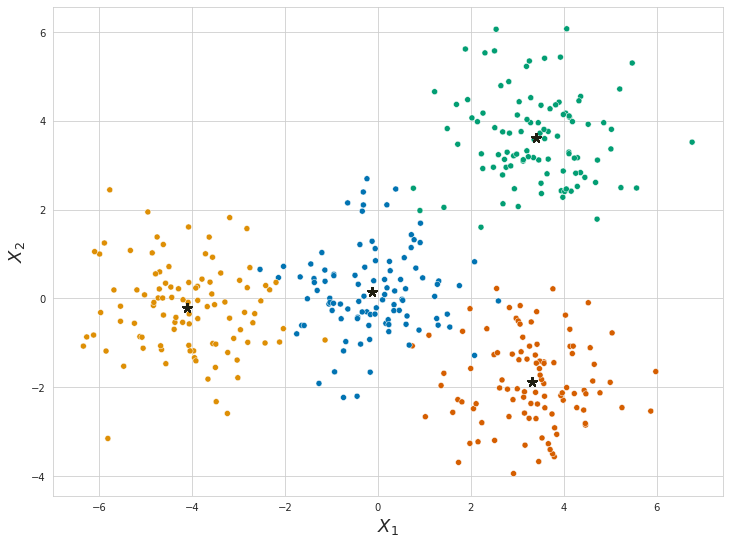

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [19]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists =np.array(dists)
            print(dists.shape)
            dists = np.concatenate(dists, axis=1)
            print(dists.shape)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        cluster_labels = None
        # пересчитаем дистанции до центров кластеризации
        dists = []
        for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
        
        dists = np.concatenate(dists, axis=1)
        
        cluster_labels = np.argmin(dists, axis=1)
            
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        
        dist = []
        dist = np.sqrt(np.sum(( X - centroid )**2, axis =1))
        dist = dist.reshape(400,1)
        return dist
    
    
    def __repr__(self):
        print(self.centroids)
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

In [20]:
cluster = MyKMeans(4, init="random", max_iter=10, visualize=False)
cluster.fit(X)


(4, 400, 1)
(400, 4)
(4, 400, 1)
(400, 4)
(4, 400, 1)
(400, 4)
(4, 400, 1)
(400, 4)
(4, 400, 1)
(400, 4)
(4, 400, 1)
(400, 4)
(4, 400, 1)
(400, 4)
(4, 400, 1)
(400, 4)
(4, 400, 1)
(400, 4)
(4, 400, 1)
(400, 4)
[[ 3.34605704 -1.86862584]
 [ 3.48057477  3.64682795]
 [-0.11246357  0.16623037]
 [-4.14007406 -0.19943566]]


Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

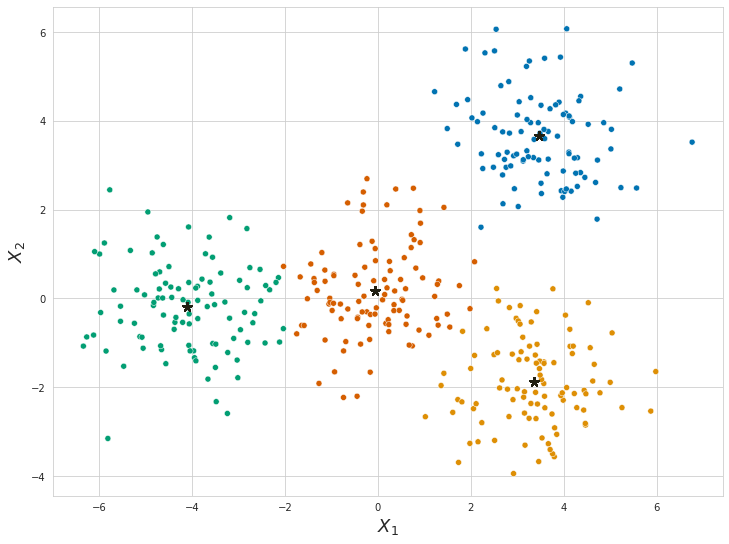

[[ 3.48057477  3.64682795]
 [ 3.35979583 -1.88515059]
 [-4.09935775 -0.19762573]
 [-0.05381062  0.16768302]]


Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [12]:
cluster_samp = MyKMeans(4, init="sample", max_iter=10, visualize=True)
cluster_samp.fit(X)

При запуске с различной инициализацией довольно сложно обнаружить разницу в результатах на глаз... по ощущениям при инициализации из точек сходимость чуть быстрее. Разность между итоговыми центрами едва заметна (выведенные циферки).

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [9]:
data = load_digits()
X, y = data.data, data.target

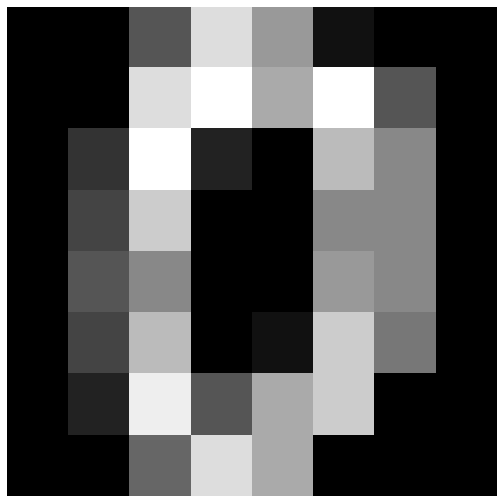

In [10]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

In [11]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

def algorithm_selection(X, y, distances, algorithms, metric):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """
    distance_tab = []
    linkage_tab = []
    if "Homogeneity" in metric:
        homogenity_tab=[]
        
    if "Completeness" in metric:
        completeness_tab=[]
    
    if "V-measure" in metric:
        v_measure_tab=[]
    
    if "Silhouette" in metric:
        silhouette_tab =[]
    
    for alg in algorithms:
        if (alg == "ward"):
            clustering = AgglomerativeClustering(n_clusters=10, affinity="euclidean", linkage = "ward")
            clustering.fit(X)
            distance_tab.append("euclidean")
            linkage_tab.append(alg)
            if "Homogeneity" in metric:
                homogenity_tab.append(metrics.homogeneity_score(y, clustering.labels_))
            if "Completeness" in metric:
                completeness_tab.append(metrics.completeness_score(y, clustering.labels_))
            if "V-measure" in metric:
                v_measure_tab.append(metrics.v_measure_score(y, clustering.labels_))
            if "Silhouette" in metric:
                silhouette_tab.append(metrics.silhouette_score(X, clustering.labels_, metric='euclidean'))
        else:
            for dist_funk in distances:
                clustering = AgglomerativeClustering(n_clusters=10, affinity=dist_funk, linkage = alg)
                clustering.fit(X)
                distance_tab.append(dist_funk)
                linkage_tab.append(alg)
                if "Homogeneity" in metric:
                    homogenity_tab.append(metrics.homogeneity_score(y, clustering.labels_))
                if "Completeness" in metric:
                    completeness_tab.append(metrics.completeness_score(y, clustering.labels_))
                if "V-measure" in metric:
                    v_measure_tab.append(metrics.v_measure_score(y, clustering.labels_))
                if "Silhouette" in metric:
                    silhouette_tab.append(metrics.silhouette_score(X, clustering.labels_, metric=dist_funk))
                
    compare_dataframe=pd.DataFrame()
    
    data = [distance_tab, linkage_tab]
    if "Homogeneity" in metric:
        data.append(homogenity_tab)
    if "Completeness" in metric:
        data.append(completeness_tab)
    if "V-measure" in metric:
        data.append(v_measure_tab)
    if "Silhouette" in metric:
        data.append(silhouette_tab)
    
    
    columns=["distance", "linkage"]
    if "Homogeneity" in metric:
        columns.append("Homogeneity")
    if "Completeness" in metric:
        columns.append("Completeness")
    if "V-measure" in metric:
        columns.append("V-measure")
    if "Silhouette" in metric:
        columns.append("Silhouette")
    
    compare_dataframe=pd.DataFrame(data, columns).T
    
    return compare_dataframe

In [12]:
distances = ["euclidean", "l1", "l2", "manhattan", "cosine"]
algorithms = ["ward","average", "single", "complete"]
metric = ["Homogeneity", "Completeness", "V-measure", "Silhouette"]

a = algorithm_selection(X, y, distances, algorithms, metric)
print(a)

     distance   linkage Homogeneity Completeness V-measure Silhouette
0   euclidean      ward    0.857513     0.879096   0.86817   0.178497
1   euclidean   average    0.655393     0.782342  0.713263   0.146625
2          l1   average    0.566751     0.778942  0.656117   0.105238
3          l2   average    0.655393     0.782342  0.713263   0.146625
4   manhattan   average    0.566751     0.778942  0.656117   0.105238
5      cosine   average    0.648268     0.808762  0.719676   0.218229
6   euclidean    single    0.005056     0.273755  0.009929  -0.133621
7          l1    single    0.005102     0.276237  0.010019  -0.203816
8          l2    single    0.005056     0.273755  0.009929  -0.133621
9   manhattan    single    0.005102     0.276237  0.010019  -0.203816
10     cosine    single     0.00505     0.273389  0.009916  -0.281789
11  euclidean  complete    0.590549     0.637772  0.613253   0.119271
12         l1  complete    0.646372     0.686109  0.665648   0.160617
13         l2  compl

Честно пытался понять, как же решить это задание по-человечески... Не очень вышло, но в целом...
Заметно, что класстеризация со связью (вычисление расстояний между "объектами") по минимальному расстоянию (single) рабоатет как-то совсем не очень хорошо. Коэффициент силуэта отрицательный, что значит, что, вероятно, эл-ты были отнесены не туда. В остальном в общем все класстеризации схожи по значению коэффициента силуэта. 
Наилучний результат, кажется, даёт класстеризация со связью по методу Варда и евклижовой метрикой. 
Также достаточно неплохо выглядит класстеризация со связью по среднему с более-менее любой метрикой расстояния. 

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [13]:
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)

##### YOUR TURN TO CODE:

In [14]:
fc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FSC-A   10000 non-null  float64
 1   SSC-A   10000 non-null  float64
 2   HLA-DR  10000 non-null  float64
 3   CD3     10000 non-null  float64
 4   CD45    10000 non-null  float64
 5   CD14    10000 non-null  float64
 6   CD56    10000 non-null  float64
 7   CD19    10000 non-null  float64
 8   CD11c   10000 non-null  float64
dtypes: float64(9)
memory usage: 781.2 KB


In [15]:
fc_data.corr()

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c
FSC-A,1.000000,0.817055,0.093181,0.053376,0.163041,0.148212,-0.117324,-0.080216,0.090589
SSC-A,0.817055,1.000000,0.179012,-0.147409,0.003049,0.458371,-0.014833,-0.133610,0.314563
HLA-DR,0.093181,0.179012,1.000000,-0.645041,-0.156292,0.262074,-0.142130,0.701287,0.373100
CD3,0.053376,-0.147409,-0.645041,1.000000,0.479488,-0.309785,-0.316389,-0.530428,-0.384175
CD45,0.163041,0.003049,-0.156292,0.479488,1.000000,-0.218609,-0.313202,-0.183365,-0.204759
CD14,0.148212,0.458371,0.262074,-0.309785,-0.218609,1.000000,0.037727,-0.173776,0.677559
CD56,-0.117324,-0.014833,-0.142130,-0.316389,-0.313202,0.037727,1.000000,-0.177014,0.049399
CD19,-0.080216,-0.133610,0.701287,-0.530428,-0.183365,-0.173776,-0.177014,1.000000,0.038654
CD11c,0.090589,0.314563,0.373100,-0.384175,-0.204759,0.677559,0.049399,0.038654,1.000000


In [16]:
fc_data.describe()

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.962458,0.165415,1.791579,3.280391,5.169845,1.097182,0.412223,1.219683,0.569898
std,0.500012,0.190773,2.027281,2.112079,0.518247,1.375876,1.176967,2.285305,1.502445
min,0.144786,0.021657,-7.634172,-2.517639,-8.329666,-8.833883,-12.358701,-9.640775,-11.085437
25%,0.798804,0.105550,0.275056,1.401943,4.922227,0.389746,-0.195978,-0.146948,-0.498781
50%,0.908574,0.130543,1.194313,4.373660,5.234119,0.672853,0.053267,0.244121,0.272297
75%,1.052034,0.162536,3.696976,4.842212,5.481218,1.065076,0.378576,0.908374,1.220576
max,42.954485,15.460997,12.946668,13.844391,13.710922,6.294236,6.461899,7.208721,6.840864


Ну, видмо, здесь 10000 клеток и 9 признаков на каждую, незаполненных значений нет. Откинуть какие-то столбцы мгновенно боязно, тк не очень понятно, что они значат. Первые два столбца достоточно сильно скоррелированы, но они "косвенным образом свидетельствуют о размере клеток", значит, наверное нужно их оба сохранить.

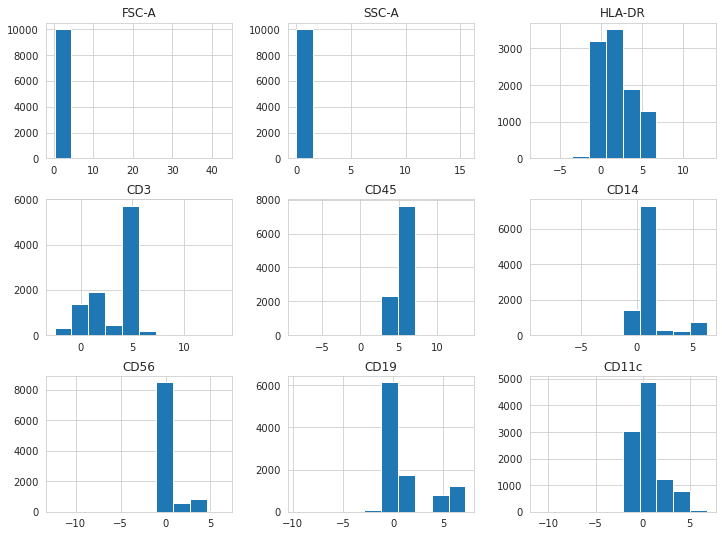

In [17]:
fc_data.hist()
plt.show()

Первы 2 гитограммы особенно радуют. Там явно что-то странное при среднем ~1 есть значения окло 42 и их очень мало. Это выбросы?! Тут у меня появилось непреодолимое желание выбросить всё, что лежит за 3 сигма от среднего по первой же колонке... 

[0.9624581482275356, 0.16541484162280232, 1.7915789050712552, 3.2803910161113636, 5.169845058026723, 1.09718232596259, 0.4122228813072155, 1.2196830340534695, 0.5698983023216351]
[0.5000122529258695, 0.19077335205860946, 2.027281076535063, 2.1120786586251072, 0.5182465558309937, 1.3758761747961348, 1.1769666472332883, 2.285304874841746, 1.5024449971964398]


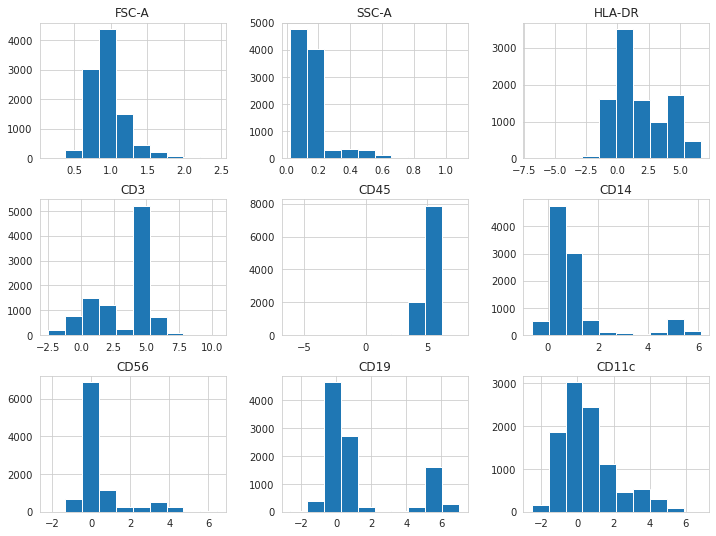

In [18]:
avgs = [fc_data[feature].mean() for feature in fc_data.columns]
stds = [fc_data[feature].std() for feature in fc_data.columns]
print(avgs)
print(stds)

fc_data_cut= fc_data[fc_data["FSC-A"] - avgs[0] < 3.0*stds[0]]
fc_data_cut.hist()
plt.show()


In [19]:
fc_data_cut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9976 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FSC-A   9976 non-null   float64
 1   SSC-A   9976 non-null   float64
 2   HLA-DR  9976 non-null   float64
 3   CD3     9976 non-null   float64
 4   CD45    9976 non-null   float64
 5   CD14    9976 non-null   float64
 6   CD56    9976 non-null   float64
 7   CD19    9976 non-null   float64
 8   CD11c   9976 non-null   float64
dtypes: float64(9)
memory usage: 779.4 KB


In [20]:
fc_data_cut.describe()

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c
count,9976.000000,9976.000000,9976.000000,9976.000000,9976.000000,9976.000000,9976.000000,9976.000000,9976.000000
mean,0.953491,0.163208,1.790661,3.276293,5.172100,1.095180,0.414556,1.215803,0.567936
std,0.251746,0.112806,2.014866,2.103234,0.455569,1.370567,1.169454,2.279116,1.493413
min,0.144786,0.021657,-6.847628,-2.517639,-6.186435,-0.643408,-2.211738,-2.639452,-2.531130
25%,0.798392,0.105495,0.276052,1.400230,4.921973,0.388714,-0.195528,-0.147895,-0.498781
50%,0.908349,0.130467,1.192333,4.374226,5.233830,0.670728,0.053267,0.243550,0.271029
75%,1.050618,0.162089,3.690598,4.841567,5.480731,1.061260,0.378098,0.904460,1.215788
max,2.451654,1.085003,6.678981,10.422402,7.612352,6.105311,6.461899,7.003157,6.840864


Кажется, что стало получше... надеюсь, что при этом мы не отрезали целый класс каки-то очень специфичных клтеок... хотя таких было бы 24 штуки и они скорее всего упали бы просто в 1 класстер

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [21]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

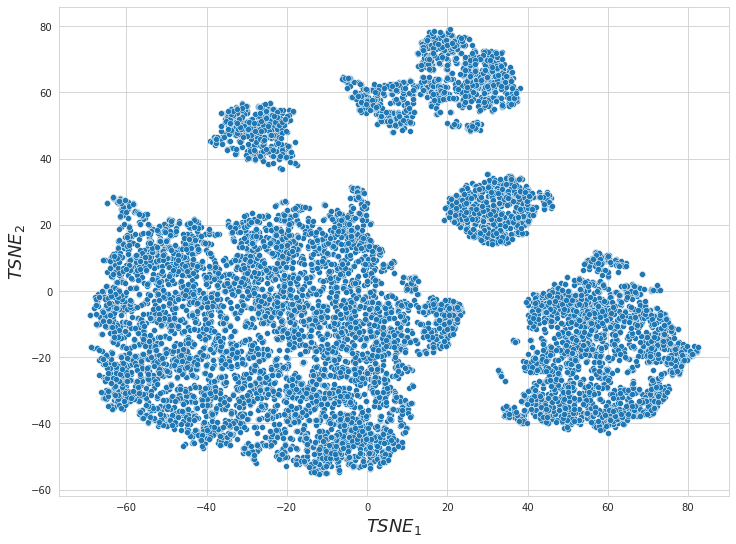

In [41]:
tsne_res = plot_tsne(fc_data_cut, n_iter=1000, perplexity=40)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(fc_data_cut)
fc_data_norm = scaler.transform(fc_data_cut)

Видимо данные нужно всё-таки отнормировать...

0.6129173299941426


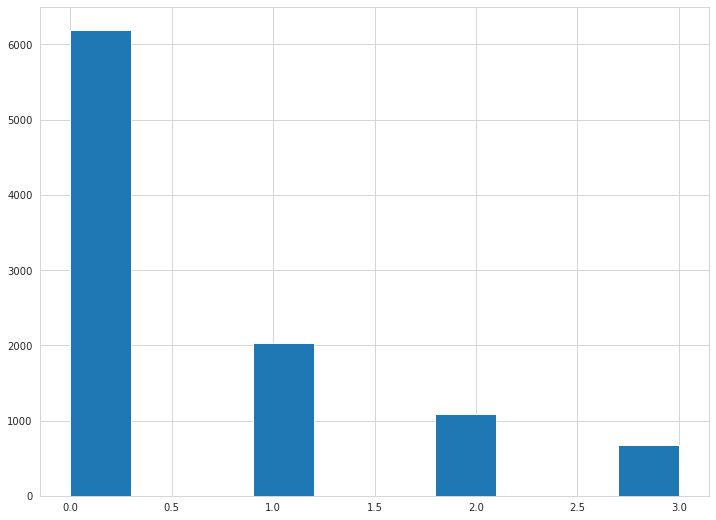

In [127]:
kmeans_cut = KMeans(n_clusters=4, random_state=SEED)
kmeans_cut.fit(fc_data_cut)
kmeans_labels_cut = kmeans_cut.labels_
plt.hist(kmeans_labels_cut)
print(metrics.silhouette_score(fc_data_cut, labels = kmeans_labels_cut, metric="euclidean"))

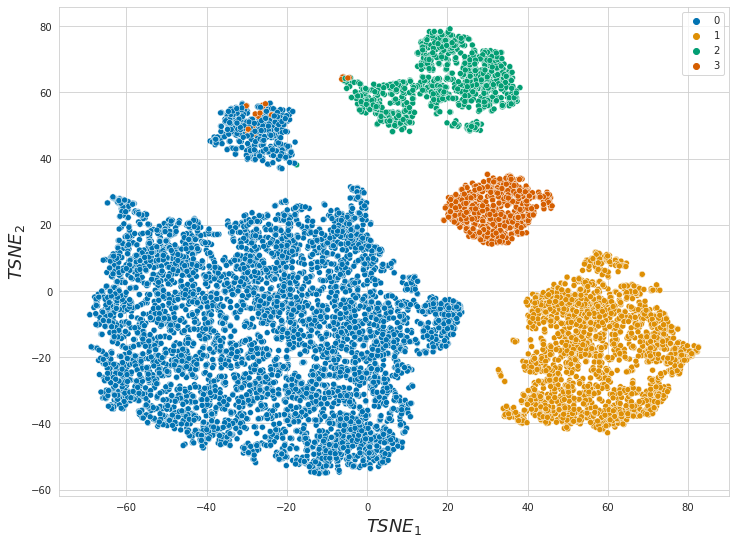

In [97]:
tsne_res_KMeans = plot_tsne(fc_data_cut, n_iter=1000, perplexity=40, color=kmeans_labels_cut)

Тут параметр "4 класстера" видится лучшим результатом как по метрике, так и по визуальной оценке рисунка tsne...

DBSCAN(eps=2.15, min_samples=50)
0.6053597343511913


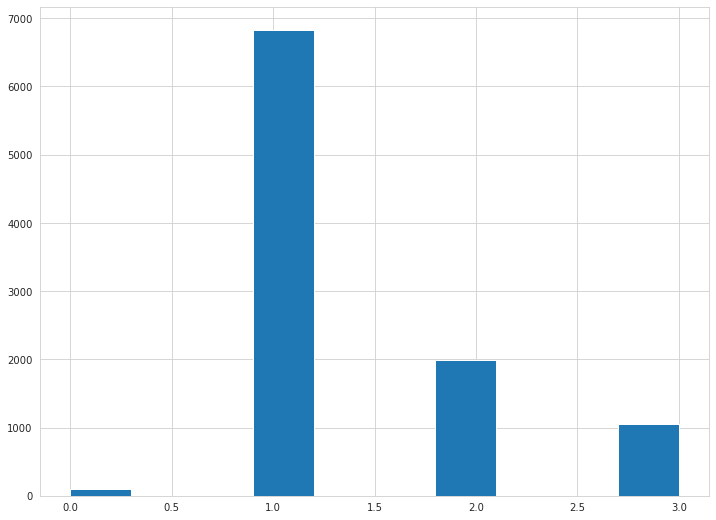

In [122]:
from sklearn.cluster import DBSCAN


clust_DBSCAN= DBSCAN(2.15, 50)
print(clust_DBSCAN)
clust_DBSCAN.fit(fc_data_cut) 
labels_DBSCAN_cut = clust_DBSCAN.labels_
labels_DBSCAN_cut[:]=labels_DBSCAN_cut[:]+1
plt.hist(labels_DBSCAN_cut)
print(metrics.silhouette_score(fc_data_cut, labels = labels_DBSCAN_cut, metric="euclidean"))

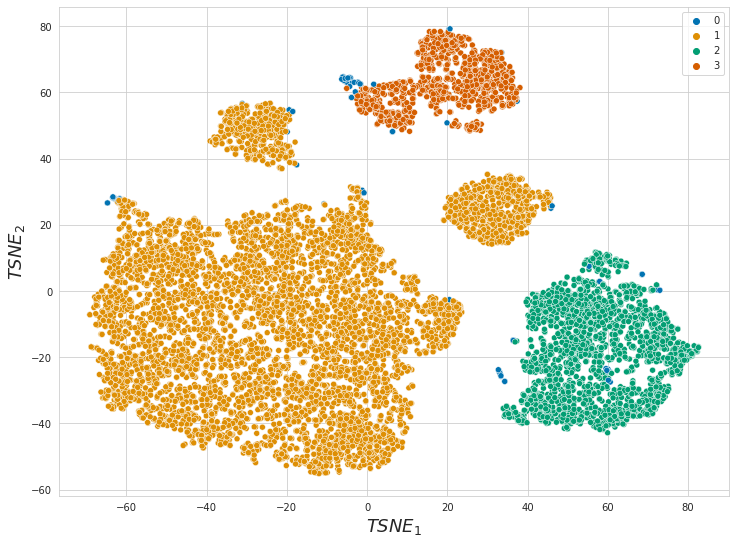

In [123]:
tsne_res = plot_tsne(fc_data_cut, n_iter=1000, perplexity=40, color=labels_DBSCAN_cut)

In [104]:
kmeans_norm = KMeans(n_clusters=5, random_state=SEED)
kmeans_norm.fit(fc_data_norm)
kmeans_labels_norm = kmeans.labels_
print(metrics.silhouette_score(fc_data_norm, labels = kmeans_labels_norm, metric="euclidean"))

0.5031822396365989


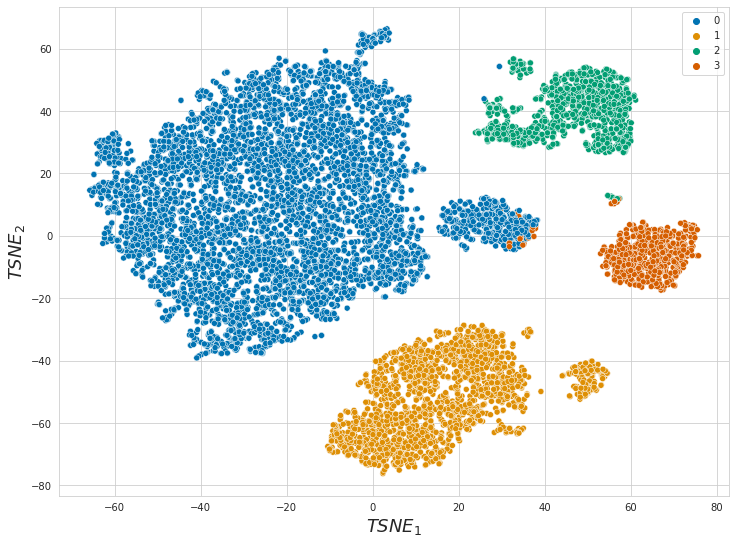

In [105]:
tsne_res_KMeans_norm = plot_tsne(fc_data_norm, n_iter=1000, perplexity=40, color=kmeans_labels_norm)

DBSCAN(eps=1.75, min_samples=45)
0.4597829333181756


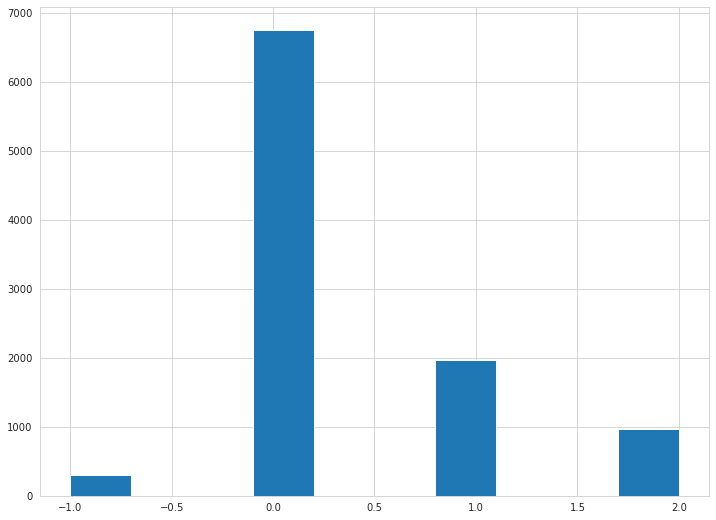

In [109]:
clust_DBSCAN_norm= DBSCAN(1.75, 45)
print(clust_DBSCAN)
clust_DBSCAN_norm.fit(fc_data_norm) 
labels_DBSCAN_norm = clust_DBSCAN_norm.labels_
plt.hist(labels_DBSCAN_norm)
print(metrics.silhouette_score(fc_data_norm, labels = labels_DBSCAN_norm, metric="euclidean"))

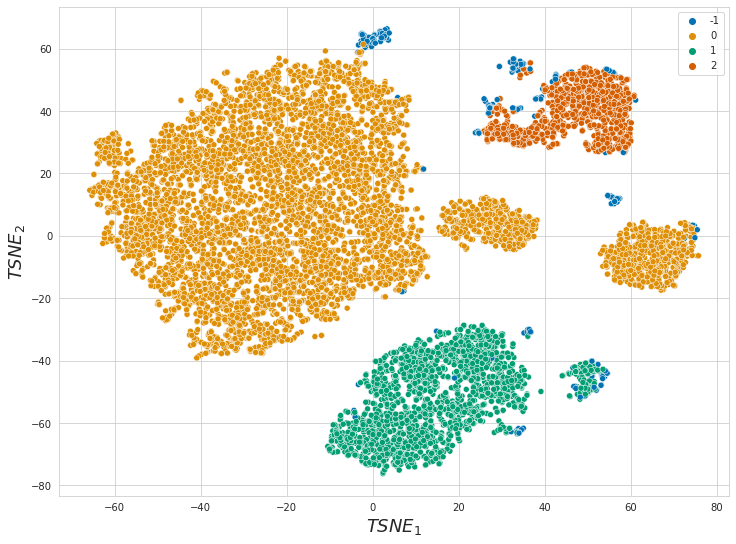

In [110]:
tsne_res_DBSCAN_norm = plot_tsne(fc_data_norm, n_iter=1000, perplexity=40, color=labels_DBSCAN_norm)

Забавно, что при нормировке данных (стандартизации) результат получается значительно худший... Возможно, это тот случай, когда реально стандартизировать данные не стоит...

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

Не удалось получить ситуацию, когда данные одного цвета. Если подглянуть в следующий пункт, можно заметить, что там 4 класса клеток Б-клетки, Т-клетки, моноциты и "другие"... При наилучшем (по моему мнению) наборе параметров DBSCAN немного уступает в метрике Kmeans. В целом их результаты визуально схожи за исключением одного сегмента (тот что в К-средних размечен меткой 3). Фомально алгоритм К-средних выигрывает у DBSCAN, хотя по-моему вопрос всё ещё дискуссионный, потому что скорее всего (предположение) различия в пометке "остальные клетки". И с одной стороны хорошо уметь отмечать шум DBSCANом, с другой хорошо иметь целый кластер с "остальными клетками" на чудесной двухмерной "карте". Но пропробуем продолжить с к-средними для к=4)

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

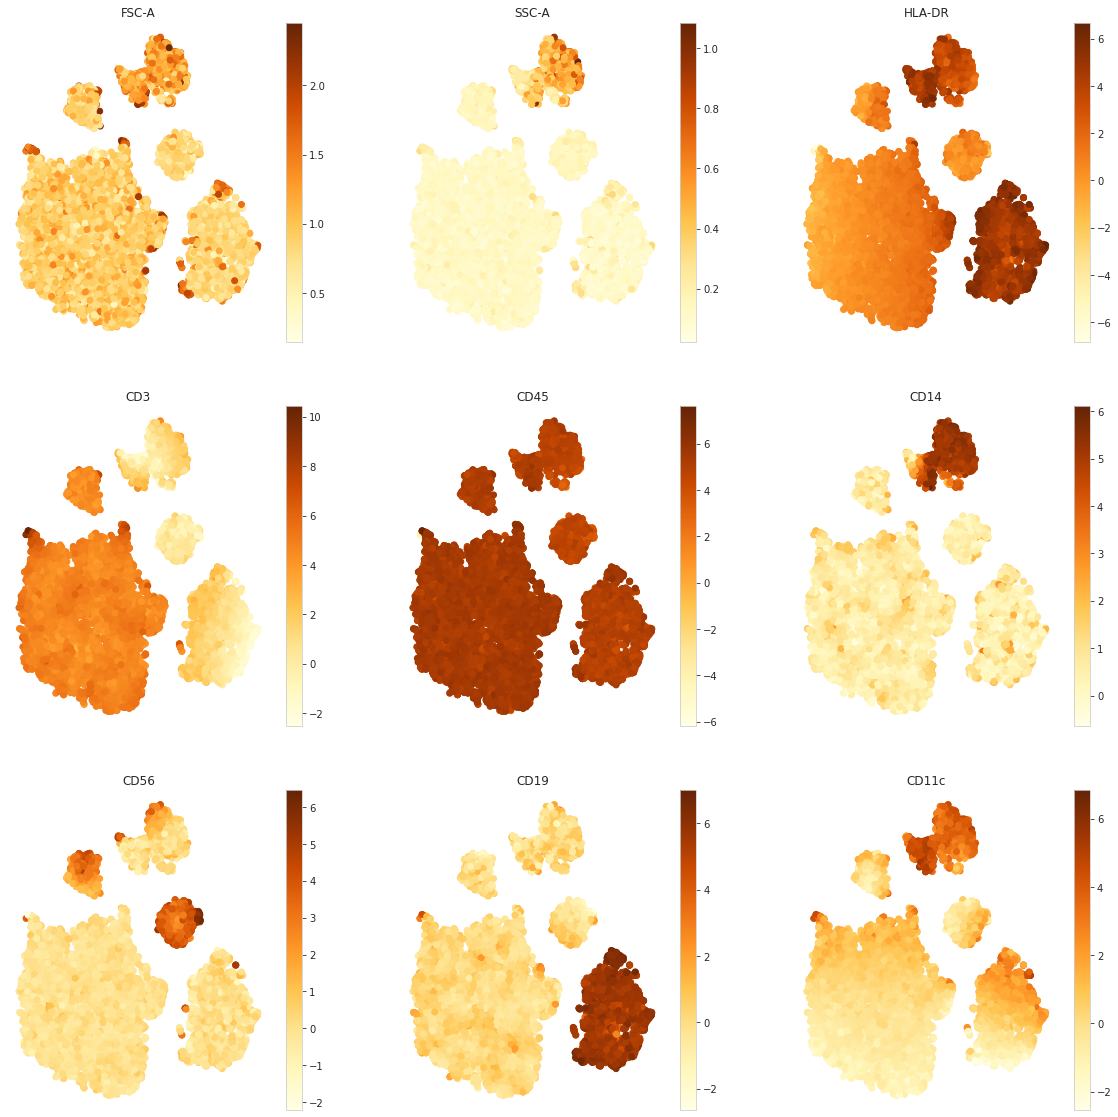

In [117]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data_cut.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data_cut[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [124]:
cell_type_cluster_map = {0: "T-cells", 
                         1: "B-cells", 
                         2: "Monocytes", 
                         3: "Other cells"}

Если правльно понял, то нужно пойти и посмотреть какие клетки что экспрессируют... Я нашёл, что Monocytes имеют "high level expression of the CD14 cell surface receptor", то есть они соответствуют лейблу 2. B-cells имеют повышенную экспрессию CD19 -> они 1, T-cells имеют повышенную экспрессию CD3 -> метка 0. Методом исключения остальные -> 3

In [139]:
labeled_fc_data.columns.values

array(['FSC-A', 'SSC-A', 'HLA-DR', 'CD3', 'CD45', 'CD14', 'CD56', 'CD19',
       'CD11c', 'Population'], dtype=object)

In [128]:
labeled_fc_data = fc_data_cut.assign(Population=kmeans_cut.labels_)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

(array([ 671., 2026., 6192., 1087.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <BarContainer object of 4 artists>)

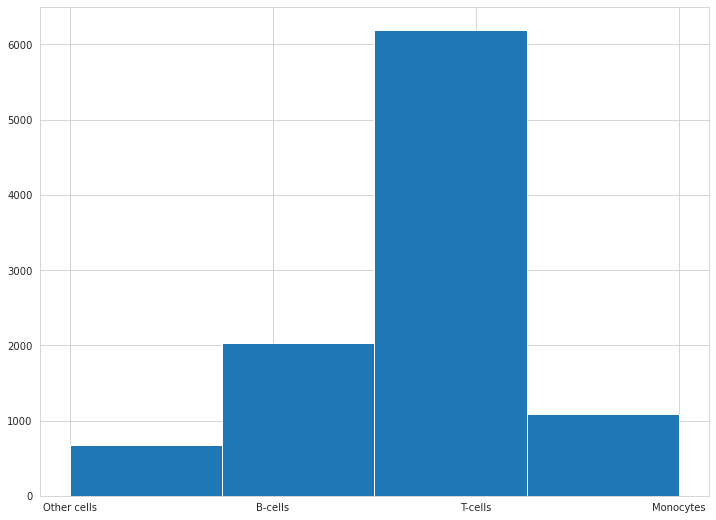

In [130]:
plt.hist(labeled_fc_data["Population"],bins=4)

In [134]:
print(labeled_fc_data.groupby("Population").size())

Population
B-cells        2026
Monocytes      1087
Other cells     671
T-cells        6192
dtype: int64


Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [135]:
labeled_fc_data.to_csv("result.csv")

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

В ходе работы с датасетом нами было выяснено, что на нём стандартизация данных работает как-то плохо, поэтому её мы применять здесь на будем. Для классификации применим алгоритм KNN.

In [160]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

names = ['FSC-A', 'SSC-A', 'HLA-DR', 'CD3', 'CD45', 'CD14', 'CD56', 'CD19', 'CD11c']
X = labeled_fc_data[names]
y = labeled_fc_data["Population"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=SEED, 
                                                    test_size=0.2)

In [161]:
KNeighbors = KNeighborsClassifier(n_neighbors=10, metric ="euclidean", n_jobs=6)
KNeighbors.fit(X_train, y_train)
prediction = KNeighbors.predict(X_test)
print("f_1 = ", f1_score(y_test, prediction, average="macro"))
unique, counts = np.unique(prediction, return_counts=True)
print(dict(zip(unique, counts)))

f_1 =  0.9921239895268908
{'B-cells': 416, 'Monocytes': 224, 'Other cells': 127, 'T-cells': 1229}


Либо что-то не так разметил, либо классификатор справляется и при таком дисбалансе классов...

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**